In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [8]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '46-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [9]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [10]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [11]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.65.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [12]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 15,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 15,
 'WIDTH': 256}

# Load data

In [13]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [14]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [15]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.0003 to 5.36e-05


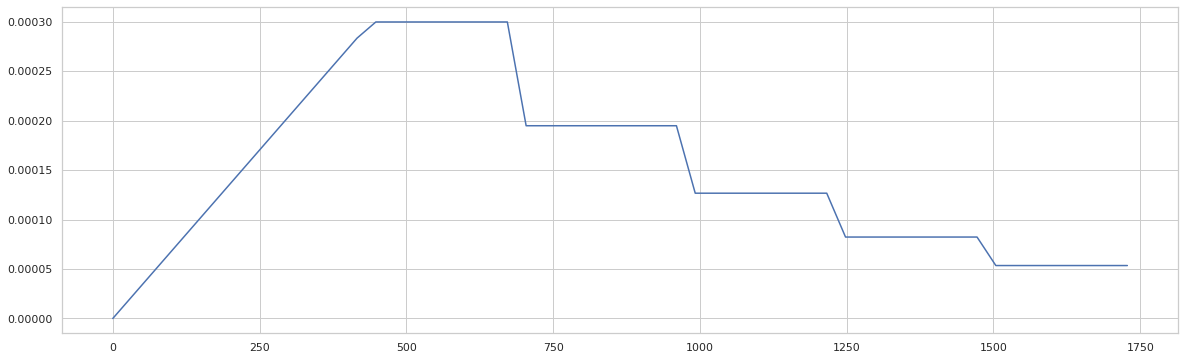

In [16]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .65
step_size = steps_per_epoch * 3

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [27]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.SpatialDropout2D(.25)(x)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [28]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
            
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 38s - auc: 0.6182 - loss: 0.5132 - val_auc: 0.5942 - val_loss: 0.3797
Epoch 2/20
93/93 - 24s - auc: 0.8580 - loss: 0.2885 - val_auc: 0.7723 - val_loss: 0.3117
Epoch 3/20
93/93 - 24s - auc: 0.8909 - loss: 0.2685 - val_auc: 0.8760 - val_loss: 0.2756
Epoch 4/20
93/93 - 24s - auc: 0.9076 - loss: 0.2569 - val_auc: 0.9088 - val_loss: 0.2577
Epoch 5/20
93/93 - 24s - auc: 0.9204 - loss: 0.2472 - val_auc: 0.9114 - val_loss: 0.2538
Epoch 6/20
93/93 - 24s - auc: 0.9308 - loss: 0.2390 - val_auc: 0.9333 - val_loss: 0.2334
Epoch 7/20
93/93 - 24s - auc: 0.9410 - loss: 0.2304 - val_auc: 0.9322 - val_loss: 0.2282
Epoch 8/20
93/93 - 24s - auc: 0.9481 - loss: 0.2234 - val_auc: 0.9482 - val_loss: 0.2191
Epoch 9/20
93/93 - 22s - auc: 0.9570 - loss: 0.2136 - val_auc: 0.9481 - val_loss: 0.2219
Epoch 10/20
93/93 - 24s - auc: 0.9602 - loss: 0.2096 - val_auc: 0.9487 - val_loss: 0.2139
Epoch 11/20
93/93 - 24s - auc: 0.9653 - loss: 0.2039 - val_auc: 0.9500 - val_loss: 0.2138
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 38s - auc: 0.5513 - loss: 0.5405 - val_auc: 0.5012 - val_loss: 0.4074
Epoch 2/20
93/93 - 24s - auc: 0.8538 - loss: 0.2905 - val_auc: 0.7646 - val_loss: 0.3226
Epoch 3/20
93/93 - 24s - auc: 0.8913 - loss: 0.2682 - val_auc: 0.8902 - val_loss: 0.2773
Epoch 4/20
93/93 - 24s - auc: 0.9107 - loss: 0.2555 - val_auc: 0.9165 - val_loss: 0.2567
Epoch 5/20
93/93 - 24s - auc: 0.9241 - loss: 0.2450 - val_auc: 0.9266 - val_loss: 0.2460
Epoch 6/20
93/93 - 22s - auc: 0.9356 - loss: 0.2359 - val_auc: 0.9320 - val_loss: 0.2474
Epoch 7/20
93/93 - 22s - auc: 0.9431 - loss: 0.2284 - val_auc: 0.9237 - val_loss: 0.2519
Epoch 8/20
93/93 - 24s - auc: 0.9499 - loss: 0.2201 - val_auc: 0.9445 - val_loss: 0.2284
Epoch 9/20
93/93 - 24s - auc: 0.9605 - loss: 0.2104 - val_auc: 0.9511 - val_loss: 0.2180
Epoch 10/20
93/93 - 22s - auc: 0.9641 - loss: 0.2056 - val_auc: 0.9536 - val_loss: 0.2194
Epoch 11/20
93/93 - 24s - auc: 0.9702 - loss: 0.1983 - val_auc: 0.9544 - val_loss: 0.2131
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.65.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 37s - auc: 0.5530 - loss: 0.5578 - val_auc: 0.5919 - val_loss: 0.4161
Epoch 2/20
97/97 - 25s - auc: 0.8552 - loss: 0.2886 - val_auc: 0.7721 - val_loss: 0.3199
Epoch 3/20
97/97 - 25s - auc: 0.8938 - loss: 0.2658 - val_auc: 0.8716 - val_loss: 0.2854
Epoch 4/20
97/97 - 25s - auc: 0.9154 - loss: 0.2519 - val_auc: 0.8904 - val_loss: 0.2785
Epoch 5/20
97/97 - 25s - auc: 0.9277 - loss: 0.2426 - val_auc: 0.9206 - val_loss: 0.2506
Epoch 6/20
97/97 - 25s - auc: 0.9368 - loss: 0.2348 - val_auc: 0.9327 - val_loss: 0.2398
Epoch 7/20
97/97 - 23s - auc: 0.9458 - loss: 0.2256 - val_auc: 0.9277 - val_loss: 0.2463
Epoch 8/20
97/97 - 25s - auc: 0.9530 - loss: 0.2178 - val_auc: 0.9444 - val_loss: 0.2278
Epoch 9/20
97/97 - 23s - auc: 0.9578 - loss: 0.2117 - val_auc: 0.9455 - val_loss: 0.2309
Epoch 10/20
97/97 - 25s - auc: 0.9625 - loss: 0.2056 - val_auc: 0.9449 - val_loss: 0.2255
Epoch 11/20
97/97 - 25s - auc: 0.9705 - loss: 0.1968 - val_auc: 0.9446 - val_loss: 0.2250
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


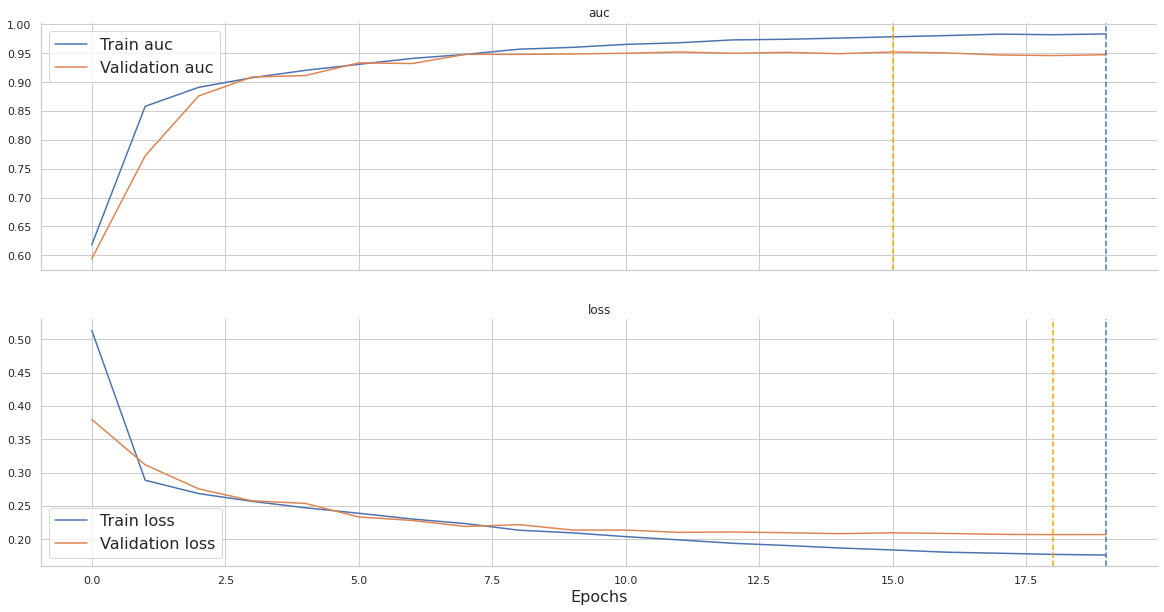

Fold: 2


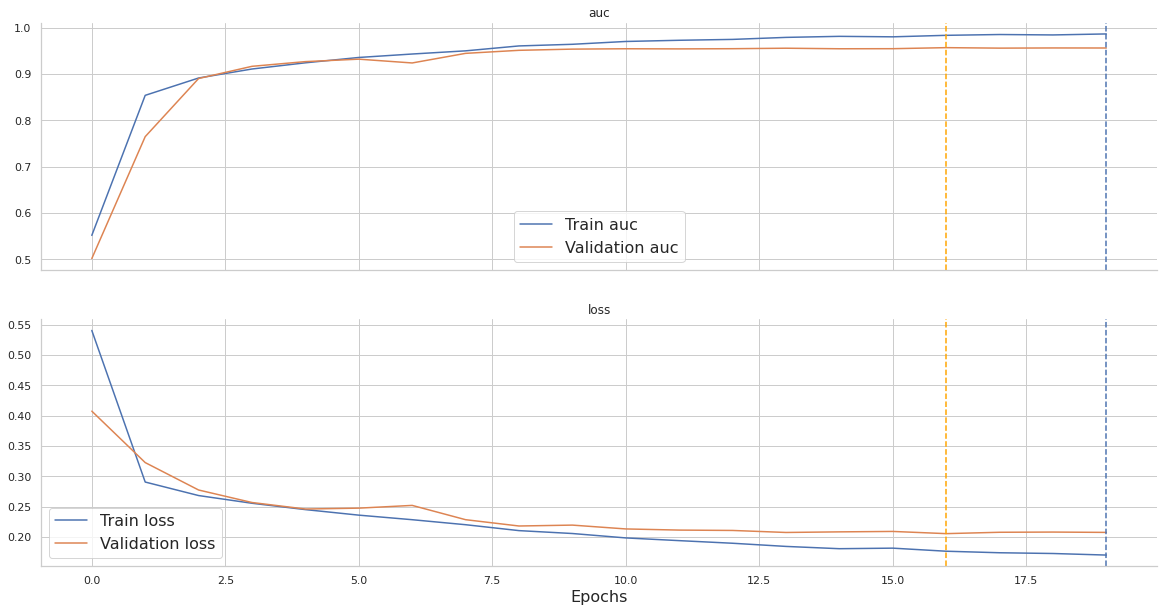

Fold: 3


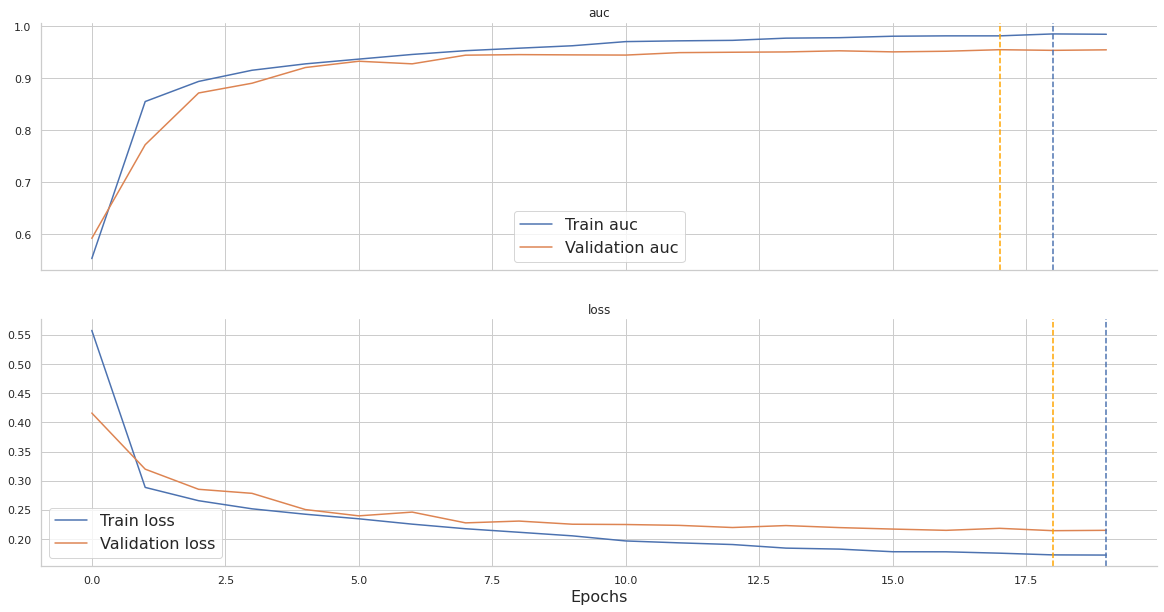

In [29]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

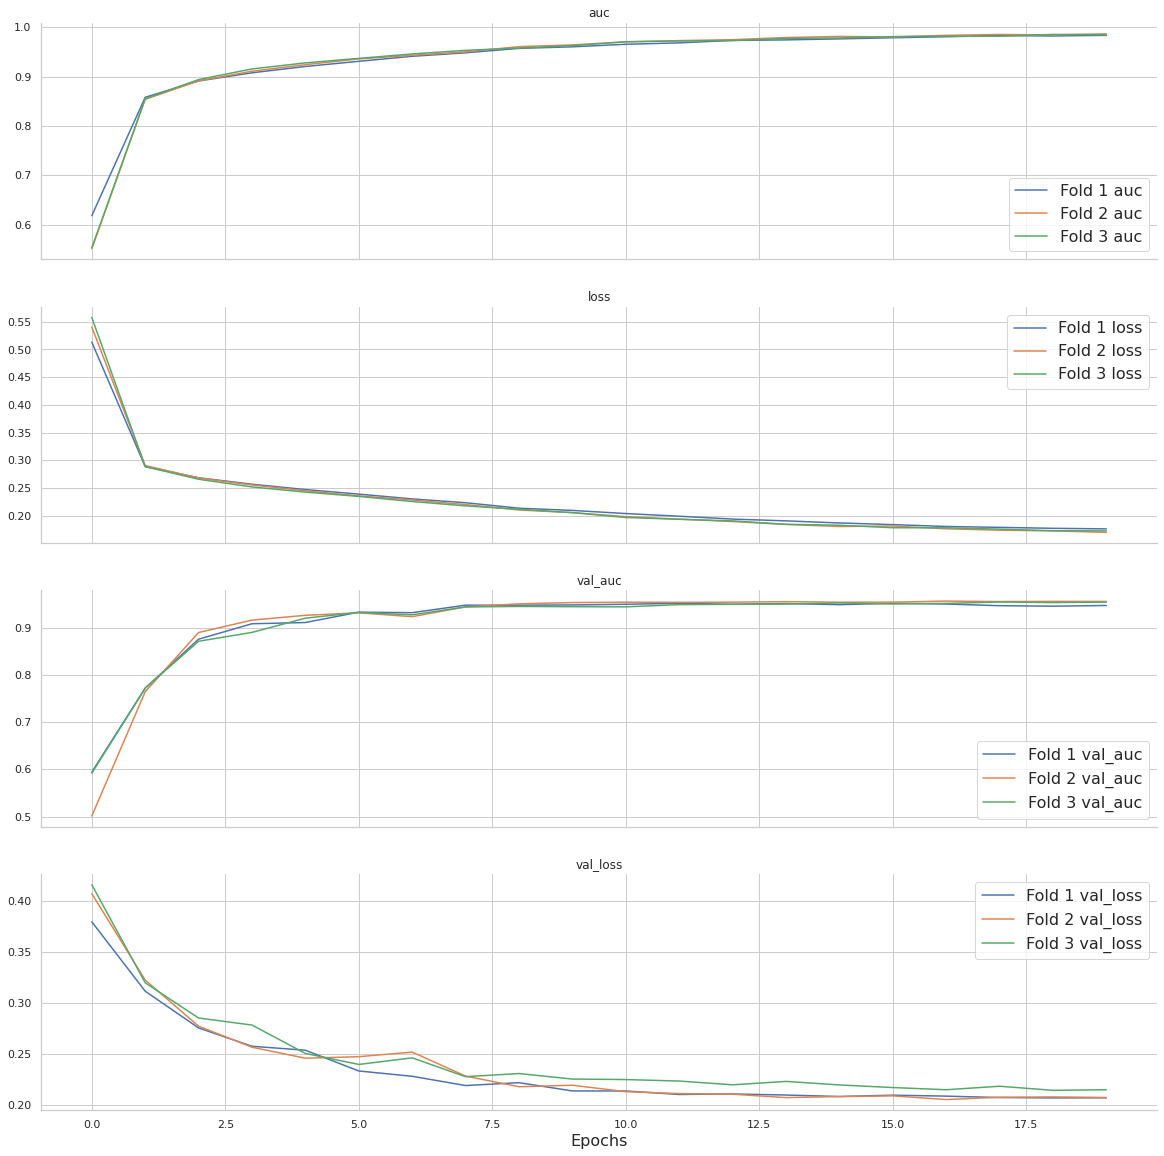

In [30]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [31]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.984505,0.856843,0.127662,0.977747,0.848892,0.989606,0.856372,0.986162,0.865265
Accuracy,0.992076,0.981057,0.011018,0.991357,0.982805,0.992216,0.981885,0.992654,0.978482
Precision,0.896710,0.437245,0.459465,0.895238,0.428571,0.897833,0.493333,0.897059,0.389831
Recall,0.622612,0.252457,0.370156,0.591195,0.252336,0.627706,0.303279,0.648936,0.201754
F1-score,0.734687,0.319726,0.414961,0.712121,0.317647,0.738854,0.375635,0.753086,0.265896
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [32]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.984505,0.856843,0.127662,0.977747,0.848892,0.989606,0.856372,0.986162,0.865265
male,0.986985,0.867691,0.119294,0.981482,0.848378,0.990460,0.886226,0.989012,0.868468
female,0.980404,0.832922,0.147482,0.971346,0.848124,0.987997,0.798665,0.981870,0.851978
head/neck,0.995812,0.852627,0.143185,0.994747,0.930862,0.997095,0.813550,0.995593,0.813467
upper extremity,0.984927,0.830918,0.154008,0.978083,0.825189,0.993744,0.834286,0.982952,0.833279
lower extremity,0.979568,0.779351,0.200217,0.972444,0.743776,0.987036,0.751570,0.979224,0.842706
torso,0.985031,0.905875,0.079156,0.979746,0.872346,0.987580,0.924952,0.987767,0.920326
0 <= age < 26,0.968430,0.786548,0.181882,0.958735,0.910326,0.975426,0.686817,0.971128,0.762500
26 <= age < 40,0.988245,0.873572,0.114673,0.989061,0.846899,0.987250,0.815877,0.988423,0.957941


# Model evaluation (best)

In [33]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.983010,0.859038,0.123972,0.977629,0.837998,0.987015,0.870295,0.984386,0.868823
Accuracy,0.991362,0.981896,0.009467,0.990713,0.983398,0.991419,0.982622,0.991956,0.979668
Precision,0.910987,0.474377,0.436610,0.936090,0.444444,0.893333,0.532258,0.903537,0.446429
Recall,0.566657,0.225569,0.341089,0.522013,0.186916,0.580087,0.270492,0.597872,0.219298
F1-score,0.697753,0.305324,0.392429,0.670256,0.263158,0.703412,0.358696,0.719590,0.294118
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.983010,0.859038,0.123972,0.977629,0.837998,0.987015,0.870295,0.984386,0.868823
male,0.985310,0.870216,0.115093,0.981361,0.846606,0.987850,0.894888,0.986718,0.869155
female,0.979061,0.835847,0.143214,0.971056,0.820481,0.985205,0.822618,0.980922,0.864441
head/neck,0.995216,0.848138,0.147079,0.994846,0.915874,0.996279,0.811201,0.994524,0.817337
upper extremity,0.982713,0.828890,0.153823,0.978008,0.815462,0.988712,0.848449,0.981419,0.822757
lower extremity,0.977461,0.794745,0.182716,0.969187,0.733412,0.984169,0.802971,0.979025,0.847852
torso,0.983805,0.903928,0.079877,0.980895,0.861486,0.985633,0.923688,0.984887,0.926611
0 <= age < 26,0.969030,0.781865,0.187165,0.967229,0.893478,0.970318,0.685451,0.969544,0.766667
26 <= age < 40,0.987156,0.874249,0.112907,0.988535,0.809714,0.984708,0.858926,0.988224,0.954107


# Confusion matrix

Fold: 1


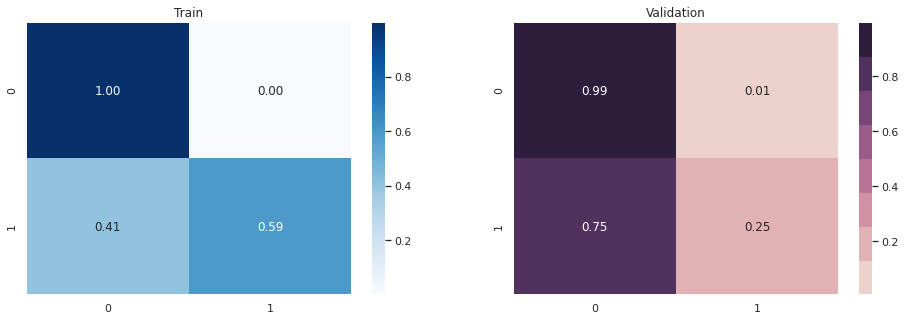

Fold: 2


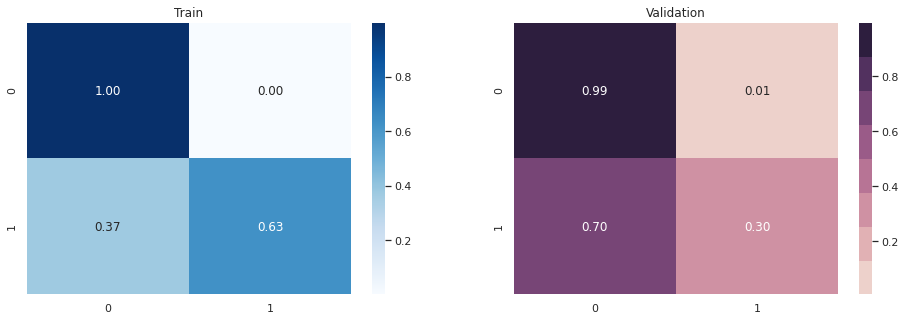

Fold: 3


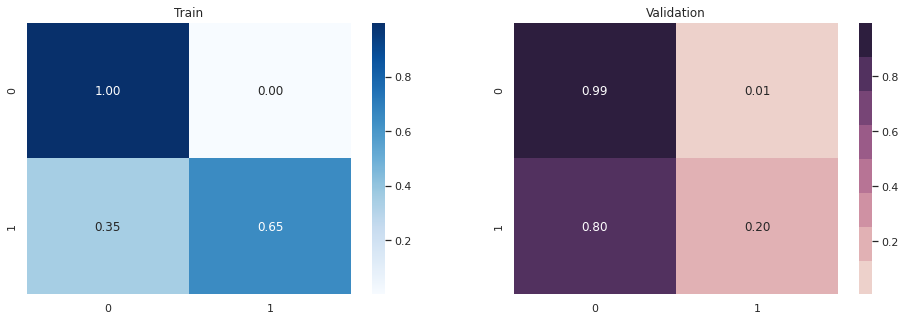

In [34]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [35]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 157
Train positive correct predictions: 157
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.014965,0.028781,0.024935,0.021112
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.014401,0.026706,0.018732,0.026565
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.013184,0.023179,0.027237,0.015505
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.014678,0.023294,0.029960,0.020134
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015707,0.021312,0.023875,0.033346
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.029296,0.036566,0.073848,0.036064
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.016172,0.046499,0.020467,0.013894
7,ISIC_0075663,female,35.0,torso,unknown,0,0.008066,0.016417,0.010580,0.013331
8,ISIC_0075914,male,30.0,torso,unknown,0,0.027492,0.036763,0.052306,0.048393
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.014982,0.033021,0.017592,0.024296


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.023684,0.017586,0.062143,0.038689
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.243047,0.691582,0.068161,0.455495
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.208596,0.203135,0.078611,0.761236
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.341830,0.626207,0.300553,0.782390
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.515410,0.939978,0.853135,0.783937
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592326,0.990475,0.972530,0.998624
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.190379,0.061424,0.119170,0.771303
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.182425,0.126579,0.261145,0.524403
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.322374,0.068584,0.797916,0.745368
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.205660,0.321842,0.607826,0.098634


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.515410,0.939978,0.853135,0.783937
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592326,0.990475,0.972530,0.998624
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.591854,0.986480,0.975972,0.996818
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.509879,0.971754,0.617793,0.959847
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.503936,0.784742,0.764219,0.970721
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.562695,0.986089,0.952736,0.874648
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.583377,0.970506,0.978106,0.968271
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.533026,0.922668,0.963457,0.779007
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.540930,0.972447,0.979843,0.752358
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.596874,0.988844,0.998328,0.997199


# Visualize test predictions

In [36]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 114|10868
Test predictions (last) 125|10857
Test predictions (tta) 100|10882
Test predictions (last tta) 120|10862
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.026146,0.026009,0.025845,0.026235
1,ISIC_0052349,male,40.0,lower extremity,0.026951,0.027370,0.028685,0.028452
2,ISIC_0058510,female,55.0,torso,0.028026,0.027190,0.023715,0.022226
3,ISIC_0073313,female,50.0,torso,0.029643,0.030152,0.027486,0.027142
4,ISIC_0073502,female,45.0,lower extremity,0.025443,0.023306,0.023974,0.023078
5,ISIC_0074618,male,50.0,lower extremity,0.035596,0.038807,0.033168,0.037303
6,ISIC_0076801,male,45.0,upper extremity,0.022501,0.023677,0.025229,0.026743
7,ISIC_0077586,male,50.0,lower extremity,0.143513,0.114411,0.041059,0.036285
8,ISIC_0082004,female,45.0,torso,0.022337,0.021958,0.025416,0.022939
9,ISIC_0082785,male,65.0,lower extremity,0.039399,0.035853,0.027707,0.024222


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.517651,0.505491,0.582559,0.547918
102,ISIC_0208233,female,60.0,lower extremity,0.884431,0.848638,0.834550,0.846118
109,ISIC_0216447,male,80.0,head/neck,0.526261,0.598864,0.159348,0.208958
255,ISIC_0351156,male,40.0,head/neck,0.523409,0.603523,0.714294,0.815077
296,ISIC_0391046,male,85.0,torso,0.686155,0.718213,0.566056,0.664087
390,ISIC_0470699,male,90.0,torso,0.554578,0.595146,0.463809,0.559517
403,ISIC_0481105,male,80.0,torso,0.861202,0.931110,0.836143,0.894002
471,ISIC_0539432,female,45.0,lower extremity,0.981982,0.981082,0.966695,0.971357
552,ISIC_0606244,male,70.0,torso,0.935749,0.948291,0.764929,0.789668
727,ISIC_0740997,male,40.0,torso,0.669913,0.676576,0.269809,0.243534


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.517651,0.505491,0.582559,0.547918
102,ISIC_0208233,female,60.0,lower extremity,0.884431,0.848638,0.834550,0.846118
109,ISIC_0216447,male,80.0,head/neck,0.526261,0.598864,0.159348,0.208958
192,ISIC_0287325,male,60.0,torso,0.353071,0.504742,0.276502,0.420462
255,ISIC_0351156,male,40.0,head/neck,0.523409,0.603523,0.714294,0.815077
296,ISIC_0391046,male,85.0,torso,0.686155,0.718213,0.566056,0.664087
390,ISIC_0470699,male,90.0,torso,0.554578,0.595146,0.463809,0.559517
403,ISIC_0481105,male,80.0,torso,0.861202,0.931110,0.836143,0.894002
471,ISIC_0539432,female,45.0,lower extremity,0.981982,0.981082,0.966695,0.971357
552,ISIC_0606244,male,70.0,torso,0.935749,0.948291,0.764929,0.789668


# Test set predictions

In [37]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.026146,0.026009,0.026078,0.025845,0.026235,0.026040
1,ISIC_0052349,0.026951,0.027370,0.027161,0.028685,0.028452,0.028569
2,ISIC_0058510,0.028026,0.027190,0.027608,0.023715,0.022226,0.022970
3,ISIC_0073313,0.029643,0.030152,0.029898,0.027486,0.027142,0.027314
4,ISIC_0073502,0.025443,0.023306,0.024375,0.023974,0.023078,0.023526
5,ISIC_0074618,0.035596,0.038807,0.037201,0.033168,0.037303,0.035236
6,ISIC_0076801,0.022501,0.023677,0.023089,0.025229,0.026743,0.025986
7,ISIC_0077586,0.143513,0.114411,0.128962,0.041059,0.036285,0.038672
8,ISIC_0082004,0.022337,0.021958,0.022147,0.025416,0.022939,0.024178
9,ISIC_0082785,0.039399,0.035853,0.037626,0.027707,0.024222,0.025965


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.046665,0.047957,0.047311,0.047418,0.049216,0.048317
std,0.084978,0.090350,0.087478,0.080398,0.086308,0.083147
min,0.009810,0.009820,0.009815,0.010560,0.010231,0.010396
25%,0.023800,0.023688,0.023809,0.024651,0.024733,0.024724
50%,0.028005,0.027777,0.027858,0.028757,0.028785,0.028806
75%,0.037230,0.036331,0.036734,0.039012,0.038548,0.038674
max,0.993262,0.996776,0.993273,0.985716,0.997014,0.991365
